# Code Assignment 18 — NYC COVID-19 Daily Counts (Time-Series)

**Dataset:** [NYC DOHMH — *COVID-19 Daily Counts of Cases, Hospitalizations, and Deaths*](https://data.cityofnewyork.us/Health/COVID-19-Daily-Counts-of-Cases-Hospitalizations-an/rc75-m7u3/about_data) 
**Focus:** Build a clean **daily** time series, **visualize** with resampling (month-end, yearly), **decompose** (trend/seasonality/residual), and **test stationarity** (ADF).  
**No forecasting models** and **no ACF/PACF** yet.

---

## Instructor Guidance

 Build a clean **daily** time series from NYC COVID-19 data using **SQLite** for filtering; visualize resampled views; run **decomposition** and **ADF**.

### Pseudocode Plan 
1) **Download CSV → pandas** (parse dates) → `pd.read_csv(path, parse_dates=['date_of_interest'])`  
2) **Normalize columns to lowercase** → `df.columns = df.columns.str.lower()`  
3) **Write to SQLite** → `import sqlite3; conn = sqlite3.connect('nyc_ts.db'); df.to_sql('covid_daily', conn, if_exists='replace', index=False)`  
4) **Filter to a time window** (choose recent 12–24 months, select only needed columns)   
5) **Set DateTime index & daily frequency** → `df.set_index('date_of_interest').asfreq('D')`  
6) **Pick ONE target series** (`CASE_COUNT` | `hosp_count` | `DEATH_COUNT`) and for now fill in missing values with zero 
7) **Resample for EDA**  
   - Month-end totals → `df[[target]].resample('M').sum()`  
   - Yearly totals → use the month-end totals to figure this code out 
8) **Decompose** (weekly seasonality) → `seasonal_decompose()`  
9) **ADF test** (raw → difference)  
   - Raw → `adfuller(s.dropna())`  
   - First difference 
10) **Short write-up**: describe trend/seasonality, ADF p-values before/after differencing, and business implications.


## Your Task

### Step 0:  Run the imports below

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

plt.style.use("seaborn-v0_8-whitegrid")
pd.set_option("display.float_format", lambda x: f"{x:,.3f}")


### Step 1:  Read in the data and look at it

In [25]:
df = pd.read_csv('../data/covid.csv')
df.head()


df['date_of_interest'] = pd.to_datetime(df['date_of_interest'], errors='coerce')

### Step 2:  Keep needed columns & filter by time window 

- Chose any time window (use most recent data) that is 6 to 12 months long 


In [26]:
# CELL 2 — Keep needed columns & filter by date in Pandas (no SQL)
df = df[['date_of_interest', 'CASE_COUNT', 'HOSPITALIZED_COUNT', 'DEATH_COUNT']]
recent_start = pd.Timestamp.today() - pd.DateOffset(months=12)
df = df[df['date_of_interest'] >= recent_start]
df = df.sort_values('date_of_interest')

# Remove commas, convert to numeric
df['CASE_COUNT'] = pd.to_numeric(df['CASE_COUNT'].astype(str).str.replace(',', ''), errors='coerce')
df['HOSPITALIZED_COUNT'] = pd.to_numeric(df['HOSPITALIZED_COUNT'].astype(str).str.replace(',', ''), errors='coerce')
df['DEATH_COUNT'] = pd.to_numeric(df['DEATH_COUNT'].astype(str).str.replace(',', ''), errors='coerce')


### Step 3:  Create a time series object and pick your Y (case count, hospitalized count, death count, etc)

- Use the `date_of_interest` column as your index and keep it at "Daily" frequency (try looking up set_index() in pandas)
- Fill in missing values of Y with zero 

In [27]:
#Build a daily time series, pick a target metric
# Set time index & ensure daily frequency
target = 'CASE_COUNT'  # choose target
ts = df.set_index('date_of_interest')[target].asfreq('D').fillna(0)
ts.head()

date_of_interest
2024-12-04    140
2024-12-05    140
2024-12-06    129
2024-12-07     78
2024-12-08    104
Freq: D, Name: CASE_COUNT, dtype: int64

### Step 4 - Visualize the Series

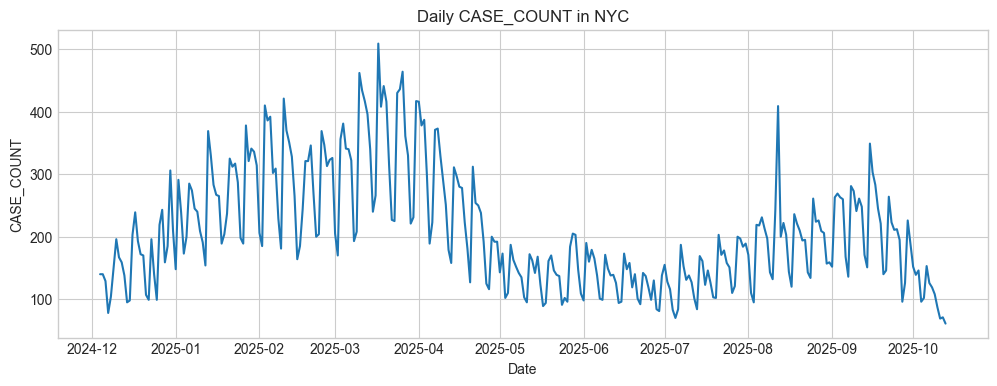

In [28]:
plt.figure(figsize=(12,4))
plt.plot(ts)
plt.title(f'Daily {target} in NYC')
plt.ylabel(target)
plt.xlabel('Date')
plt.show()

In [29]:
df.dtypes

date_of_interest      datetime64[ns]
CASE_COUNT                     int64
HOSPITALIZED_COUNT             int64
DEATH_COUNT                    int64
dtype: object

### Step 5 - Resampling EDA:  Month-end and Yearly totals 

- Use the `.resample()` function to resample the series to month end and yearly 
- Visualize both resampled series 

/var/folders/_z/410cfm6x4fl_4m_6s41fnf4w0000gp/T/ipykernel_5150/1445996003.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  m_end = ts.resample('M').sum() # Month-end totals
/var/folders/_z/410cfm6x4fl_4m_6s41fnf4w0000gp/T/ipykernel_5150/1445996003.py:3: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  y_sum = ts.resample('Y').sum()  # Yearly totals


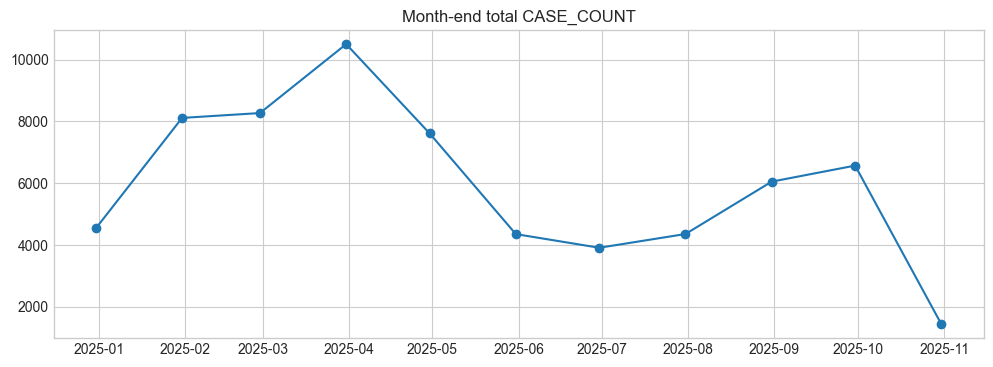

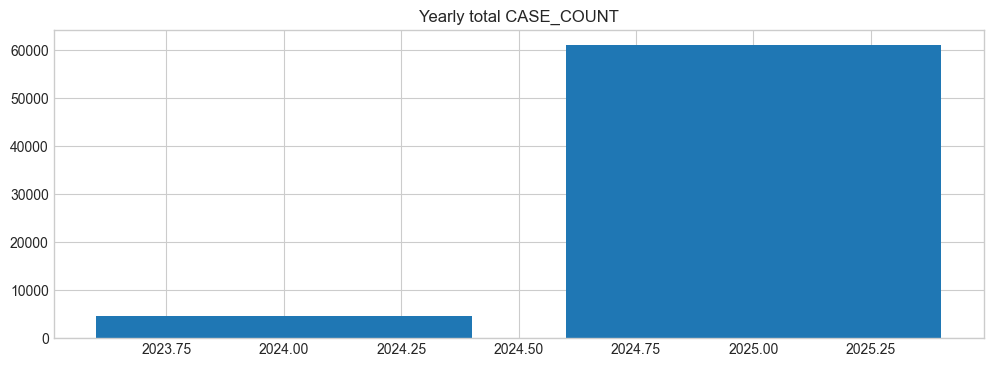

In [31]:
# CELL 5 — Resampling EDA: Month-end and Yearly totals (Pandas-only)
m_end = ts.resample('M').sum() # Month-end totals
y_sum = ts.resample('Y').sum()  # Yearly totals

plt.figure(figsize=(12,4))
plt.plot(m_end, marker='o')
plt.title(f'Month-end total {target}')
plt.show()

plt.figure(figsize=(12,4))
plt.bar(y_sum.index.year, y_sum)
plt.title(f'Yearly total {target}')
plt.show()

### Step 6 - Decompose the original time series object (use period = 7 since that represents weekly seasonality)
- Make a visual of the decomposition

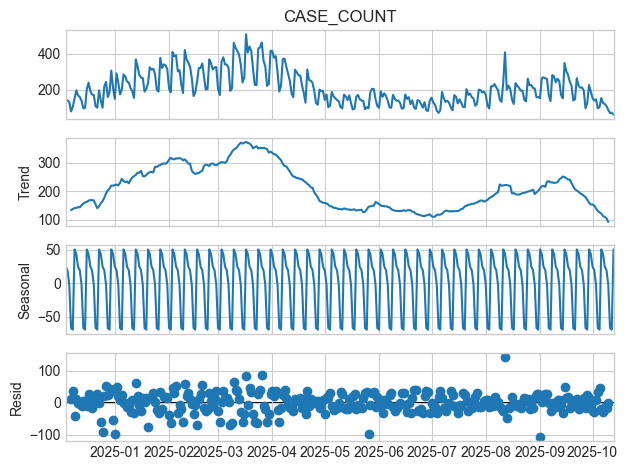

In [32]:
# CELL 6 — Decomposition (weekly seasonality → period=7)
decomp = decomp = seasonal_decompose(ts, period=7)
decomp.plot()
plt.show()

### Step 7 - Do the ADF test for stationarity on the original time series and for taking a difference of 1 on the time series 
- Be sure to drop missing values (if you didn't above) 

In [33]:
# CELL 7 — ADF stationarity test: raw → difference (1) → (optional) seasonal diff(7)
from statsmodels.tsa.stattools import adfuller

adf_raw = adfuller(ts.dropna())
print("ADF raw:", adf_raw[0], "p-value:", adf_raw[1])

ts_diff = ts.diff().dropna()
adf_diff = adfuller(ts_diff)
print("ADF diff(1):", adf_diff[0], "p-value:", adf_diff[1])


ADF raw: -1.325723713626836 p-value: 0.6173230711158149
ADF diff(1): -3.5525373526037414 p-value: 0.006735998073218494


## We Share — Reflection 

1) **Narrative:** One sentence describing the series over your window (trend + weekly seasonality + volatility).  
2) **Stationarity:** Which transform (if any) produced p < 0.05? Why does that matter before modeling?  
3) **Operational lens:** Based on month-end and yearly views, what **calendar effects** would you brief stakeholders about?


Narrative: Over the past year, daily COVID-19 cases show a weekly pattern (fewer cases on weekends) with an overall decreasing trend, but there are random spikes here and there.

Stationarity: The original series isn’t stationary (ADF p > 0.05), but after taking a first difference, it becomes stationary (p < 0.05), which is important if we want to do any time-series modeling later.

Operational lens: Month-end and yearly totals show seasonal effects — more cases in winter, fewer in summer, plus weekend/weekday reporting differences. Stakeholders could use this info to plan testing, staffing, and resources better.